# 15. Ajuste avanzado modelo Support Vector Machine, clasificacion binaria con datos desequilibrados, incluyendo variable ciclo
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No     |
| :-------                  | :------:    |
| Escalado de datos         | No          |
| Ajuste de hiperparametros | Si          |
| Sobremuestreo             | No          |
| Ajuste de pesos de clase  | Si          |
| Incluye variable ciclo    | Si          |


### Cargar librerias

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import pandas_profiling
np.random.seed(9999) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

# sobremuestreo
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot
from numpy import arange
from pprint import pprint
from sklearn.metrics import fbeta_score

Using TensorFlow backend.


### Funciones

In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla potencial"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla Potencial"})
    cm.fit(data_train, label_train)
    cm.score(data_test, label_test)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# ruta para grabar medidas de desempeño
ruta4a = "D:/alexh/Documents/Maestria en estadistica/proyecto de grado/cuadernos proyecto/Nasa Turbo Fan/Modelos 4a.xlsx"
writer = pd.ExcelWriter(ruta4a, engine='openpyxl')

### Preparar datos agil

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train['clase2']=train['clase1']
train.loc[train['ttf']<=15, 'clase2'] =2
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test['clase2']=test['clase1']
test.loc[test['ttf']<=15, 'clase2'] =2

# incluyendo la variable ciclo ID
data_train=train.iloc[:,np.r_[1:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[1:26]]
label_test=test.iloc[:,27]
label_train2=train.iloc[:,28]
label_test2=test.iloc[:,28]



Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

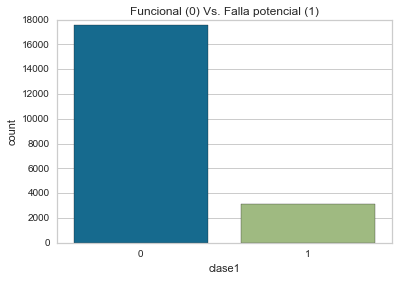

In [5]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [6]:
print("numero de dimensiones =", data_train.ndim)
print("tamaño de la tabla =", data_train.shape)
print("total datos =", data_train.size)

numero de dimensiones = 2
tamaño de la tabla = (20631, 25)
total datos = 515775


In [7]:
print("numero de dimensiones =", label_train.ndim)
print("tamaño de la tabla =", label_train.shape)
print("total datos =", label_train.size)

numero de dimensiones = 1
tamaño de la tabla = (20631,)
total datos = 20631


In [8]:
data_train.head()

,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Modelos de clasificacion binaria 

## Support Vector Machine Classifier hiperparametros por defecto

In [15]:
modelo1=SVC()
modelo1.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)



MATRIZ DE CONFUSION




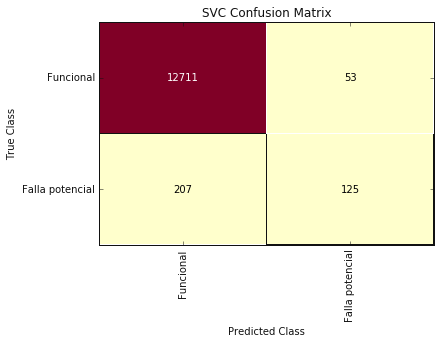



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9801466096518021
ROC AUC: 0.6861768603716023
------------------------------------------------------------
Precisión por clase: [0.98397585 0.70224719]
Sensibilidad - Recall por clase: [0.9958477  0.37650602]
F1 por clase: [0.98987618 0.49019608]
------------------------------------------------------------
F1 Macro: 0.74003612814957
F1 Micro: 0.9801466096518021
F1 Weighted: 0.9772086616022753
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.6861768603716023
Sensibilidad - Recall Micro: 0.9801466096518021
Sensibilidad - Recall Weighted: 0.9801466096518021
------------------------------------------------------------
Precisión Macro: 0.8431115193328358
Precisión Micro: 0.9801466096518021
Precisión Weighted: 0.9768336734023326
------------------------------------------------------------
Verdaderos positivos - True Positives: 125
Verdaderos negativos - True Negatives: 12711
Falsos positivos

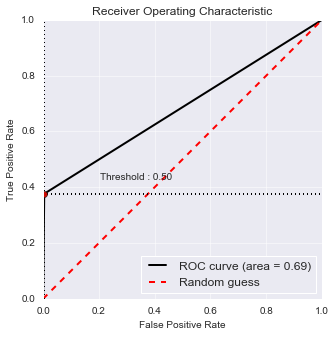

In [16]:
label_pred1 = modelo1.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1, label_pred1)

## Grid Search with Cross Validation

In [21]:

model = SVC(gamma='scale')
parameters= {'C': [0.1, 1, 10, 100, 500, 1000]}  
acc_scorer=make_scorer(fbeta_score, beta=1)

grid = GridSearchCV(estimator = model, param_grid=parameters, cv=3, verbose=2, scoring=acc_scorer, n_jobs = -1)

%time grid.fit(data_train, label_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    9.7s remaining:   25.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   13.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   13.1s finished


Wall time: 17.3 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(fbeta_score, beta=1), verbose=2)

In [22]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'C': 1000}
0.7654746347213043
5


In [23]:
modelo2a= grid.best_estimator_
modelo2a.fit(data_train, label_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
label_pred2a = modelo2a.predict(data_test)



MATRIZ DE CONFUSION




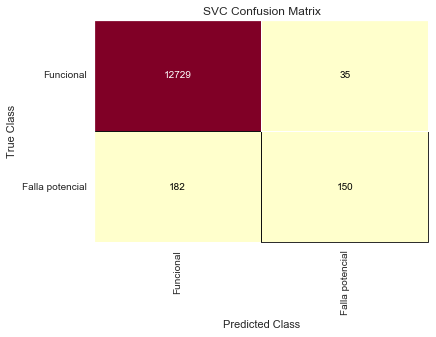



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9834300549786195
ROC AUC: 0.7245325708978189
------------------------------------------------------------
Precisión por clase: [0.98590349 0.81081081]
Sensibilidad - Recall por clase: [0.99725791 0.45180723]
F1 por clase: [0.9915482  0.58027079]
------------------------------------------------------------
F1 Macro: 0.7859094958367785
F1 Micro: 0.9834300549786195
F1 Weighted: 0.9811218013659436
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7245325708978188
Sensibilidad - Recall Micro: 0.9834300549786195
Sensibilidad - Recall Weighted: 0.9834300549786195
------------------------------------------------------------
Precisión Macro: 0.8983571519780954
Precisión Micro: 0.9834300549786195
Precisión Weighted: 0.9814646743812477
------------------------------------------------------------
Verdaderos positivos - True Positives: 150
Verdaderos negativos - True Negatives: 12729
Falsos positiv

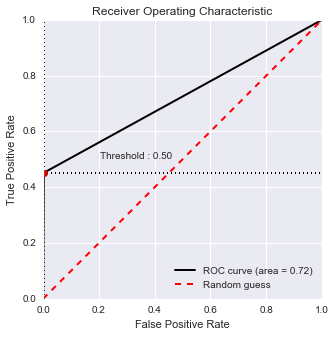

In [25]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo2a, label_pred2a)

## Support Vector Machine ponderada 

Clasificacion binaria con base desequilibrada y ponderacion de pesos


## Grid Search Weighted Support Vector Machine, con validacion cruzada estratificada

In [32]:
# definir el modelo
model = SVC(gamma='scale')
# defini cuadricula
balance = [{0:1,1:1}, {0:1,1:5}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)

# definir procedimiento de evaluacion 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

acc_scorer=make_scorer(fbeta_score, beta=1)

# grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring=acc_scorer, verbose=2)

# ejecutar grid search
grid_result = grid.fit(data_train, label_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    9.7s remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   24.5s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   24.7s finished


In [33]:
# reportar la mejor configuracion
print('mejor: %f usando %s' % (grid_result.best_score_, grid_result.best_params_))
# reportar las mejores configuraciones
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

mejor: 0.586383 usando {'class_weight': {0: 1, 1: 5}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.586383 (0.045436) with: {'class_weight': {0: 1, 1: 5}}
0.461149 (0.021223) with: {'class_weight': {0: 1, 1: 10}}
0.261262 (0.000081) with: {'class_weight': {0: 1, 1: 100}}


La mejor configuracion es 0:1, 1:5

In [36]:
modelo4=SVC(class_weight={0:1,1:5})
modelo4.fit(data_train, label_train)

C:\Users\alexh\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 5}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)



MATRIZ DE CONFUSION




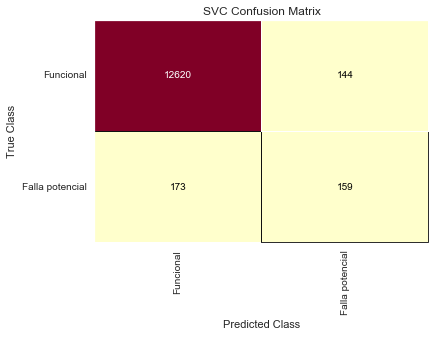



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9757941356139279
ROC AUC: 0.7338169663926781
------------------------------------------------------------
Precisión por clase: [0.98647698 0.52475248]
Sensibilidad - Recall por clase: [0.98871827 0.47891566]
F1 por clase: [0.98759635 0.5007874 ]
------------------------------------------------------------
F1 Macro: 0.744191877412201
F1 Micro: 0.9757941356139279
F1 Weighted: 0.975255136698283
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7338169663926782
Sensibilidad - Recall Micro: 0.9757941356139279
Sensibilidad - Recall Weighted: 0.9757941356139279
------------------------------------------------------------
Precisión Macro: 0.7556147274228713
Precisión Micro: 0.9757941356139279
Precisión Weighted: 0.97477168519959
------------------------------------------------------------
Verdaderos positivos - True Positives: 159
Verdaderos negativos - True Negatives: 12620
Falsos positivos -

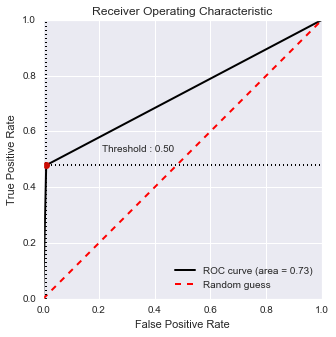

In [37]:
label_pred4 = modelo4.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo4, label_pred4)